# =============================================
# KNN Analysis: OASIS Dataset
# =============================================

In [24]:
# Import Libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Load and Inspect dataset
df = pd.read_csv('syndrome_data.csv')

# Display first few rows
print(df.shape)
df.head()

(436, 12)


,ID,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF,Delay
0,OAS1_0001_MR1,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306,NaN
1,OAS1_0002_MR1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531,NaN
2,OAS1_0003_MR1,F,R,73,4.0,3.0,27.0,0.5,1454,0.708,1.207,NaN
3,OAS1_0004_MR1,M,R,28,NaN,NaN,NaN,NaN,1588,0.803,1.105,NaN
4,OAS1_0005_MR1,M,R,18,NaN,NaN,NaN,NaN,1737,0.848,1.010,NaN


In [25]:
# Drop unnecessary columns

# ID and Delay don’t help prediction

df = df.drop(columns=['ID', 'Delay'])
df.head(2)

,M/F,Hand,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,F,R,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,F,R,55,4.0,1.0,29.0,0.0,1147,0.810,1.531


In [26]:
# Check for missing values
df.isnull().sum()

M/F       0
Hand      0
Age       0
Educ    201
SES     220
MMSE    201
CDR     201
eTIV      0
nWBV      0
ASF       0
dtype: int64

In [27]:
# Handle missing values in Educ and SES

# I am gonna fill (impute) these missing values with the median, since they are numeric and ordinal

df['Educ'] = df['Educ'].fillna(df['Educ'].median())
df['SES'] = df['SES'].fillna(df['SES'].median())

In [28]:
# Handle missing values in target columns (MMSE, CDR)

# For modeling, I drop rows that have missing target values

df = df.dropna(subset=['MMSE', 'CDR'])

In [29]:
# Now both MMSE and CDR columns will have no NaN values

# I will confirm with:

df.isnull().sum()

M/F     0
Hand    0
Age     0
Educ    0
SES     0
MMSE    0
CDR     0
eTIV    0
nWBV    0
ASF     0
dtype: int64

In [30]:
print(df['M/F'].unique())
print(df['Hand'].unique())

['F' 'M']
['R']


In [31]:
# Since Hand column shows only ‘R’, meaning all participants are right-handed. 
# This means there is no variation in this column — it’s the same for everyone.
# Hence Such a column doesn’t help the model because it provides no useful information
#KNN can’t learn from a constant value
# I will simply safely drop the Hand column from my data 

df = df.drop(columns=['Hand'])

In [32]:
# Encode gender
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['M/F'] = le.fit_transform(df['M/F'])

In [33]:
# The KNN classifier expects categorical class labels, but in the OASIS dataset, CDR values are continuous (numeric with decimals)
# Convert CDR to categorical classes to perform KNN classification
df['CDR'] = df['CDR'].map({0.0: 0, 0.5: 1, 1.0: 2, 2.0: 3})

# KNN Classification
Goal: Predict CDR (Cognitive Decline Rating)

In [34]:
# Define Features (X) and Target (y)

# I will predict CDR, so that’s our target variable.
# All other columns (except ID and Delay) are features.

X = df.drop(columns=['CDR'])
y = df['CDR']


In [35]:
# Split Data (Train/Test)

# I will use 80% for training and 20% for testing

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
# Scale the Features

# KNN is distance-based, so we scale all numeric features.

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [37]:
# Train KNN Classifier

# I will start with k=5 neighbors as a baseline.

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [38]:
# Evaluate the Model

# I will check accuracy, confusion matrix, and classification report

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = knn.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.5957446808510638


# Insights
Accuracy: 0.596 ≈ 60%


Overall, the model correctly predicted about 60% of cases.

For a multiclass dataset like this, accuracy alone can be misleading, especially if classes are imbalanced (some classes have very few samples).

In [39]:
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Confusion Matrix:
 [[25  5  0]
 [11  2  2]
 [ 1  0  1]]


# Insights From Confusion Matrix

Class 0 (No dementia) is predicted pretty well (25/30 correct).

Class 1 (Very mild) and Class 2 (Mild/Moderate) are harder for the model, low recall and precision — likely due to few samples.

In [40]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.83      0.75        30
           1       0.29      0.13      0.18        15
           2       0.33      0.50      0.40         2

    accuracy                           0.60        47
   macro avg       0.43      0.49      0.44        47
weighted avg       0.54      0.60      0.55        47



# Insights From Precision, Recall and F1-score 

Observations:

Class 0 → Good precision & recall → model does well on the majority class.

Class 1 → Poor precision & recall → model struggles, likely due to class imbalance.

Class 2 → Very small sample (support=2), metrics are unstable → not reliable

In [41]:
# I will now Consider combining classes (e.g., 0 = No dementia, 1+2 = Dementia) and simplifies into binary classification,
# and i will check if it improves KNN performance

# 0 = No dementia, 1 = Dementia (combining 1 and 2)
df['CDR_binary'] = df['CDR'].apply(lambda x: 0 if x == 0 else 1)

In [42]:
# Check the distribution:

print(df['CDR_binary'].value_counts())

CDR_binary
0    135
1    100
Name: count, dtype: int64


# Insights:

This dataset is relatively balanced:

135 healthy vs 100 dementia → roughly 57% vs 43%

This is good for KNN, because the model won’t be heavily biased toward one class.

I don’t need advanced oversampling techniques (like SMOTE) for this dataset, although I could experiment to see small improvements.

In [43]:
# Features
X = df.drop(columns=['CDR', 'CDR_binary'])
y = df['CDR_binary']  # USE THIS BINARY COLUMN

In [44]:
# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [45]:
# Scale the features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [46]:
# Train KNN Classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_scaled, y_train)

y_pred = knn.predict(X_test_scaled)

In [47]:
# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.7659574468085106


# Insights
The model correctly predicts 77% of cases.

This is a solid improvement compared to the multiclass KNN (~60%).

Simplifying to binary classes clearly helped.

The model correctly predicts 77% of cases.

In [48]:
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Confusion Matrix:
 [[22  5]
 [ 6 14]]


# Confusion Matrix Interpretation:

True Positives (0 correctly predicted) = 22

True Positives (1 correctly predicted) = 14

False Negatives / Positives are reasonably low.

The model is balanced, catching both healthy and dementia cases reasonably well.

In [49]:
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80        27
           1       0.74      0.70      0.72        20

    accuracy                           0.77        47
   macro avg       0.76      0.76      0.76        47
weighted avg       0.76      0.77      0.77        47



# Classification Report
# Precision: 
Of all predicted as a class, how many were correct

No dementia: 79% correct

Dementia: 74% correct

# Recall:
Of all actual samples, how many did we correctly predict

No dementia: 81%

Dementia: 70%

# F1-score:
Balance between precision and recall → good (~0.72–0.80)

# Insights:

Model is slightly better at predicting No Dementia, but overall performance is balanced.

This is good for a KNN model with simple preprocessing.

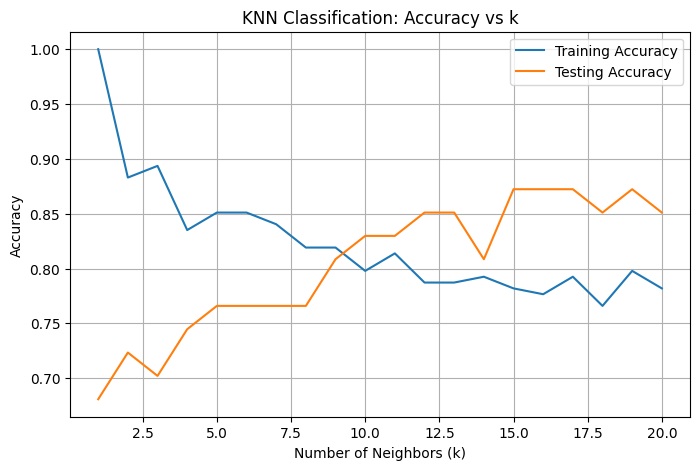

In [50]:
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

train_accuracies = []
test_accuracies = []
neighbors = range(1, 21)

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_accuracies.append(knn.score(X_train_scaled, y_train))
    test_accuracies.append(knn.score(X_test_scaled, y_test))

plt.figure(figsize=(8,5))
plt.plot(neighbors, train_accuracies, label="Training Accuracy")
plt.plot(neighbors, test_accuracies, label="Testing Accuracy")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.title("KNN Classification: Accuracy vs k")
plt.legend()
plt.grid(True)
plt.show()


# =============================================
# KNN Classification: Tuning k
# =============================================

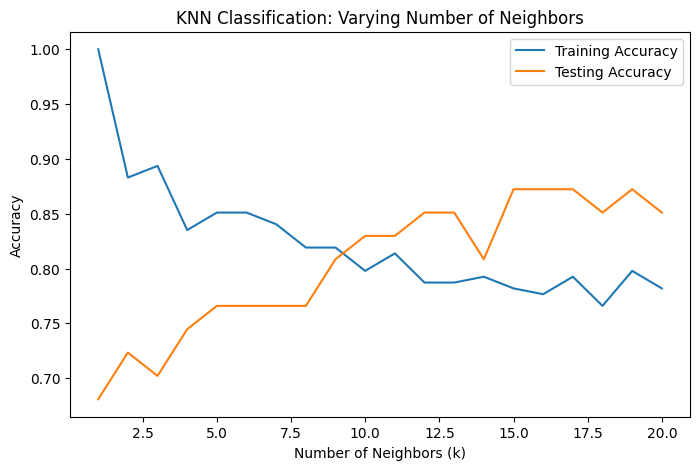

In [51]:
# Tune the Number of Neighbors (k)

# Let’s find the best k by checking accuracy for different values.

train_accuracies = {}
test_accuracies = {}
neighbors = range(1, 21)

for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    train_accuracies[k] = knn.score(X_train_scaled, y_train)
    test_accuracies[k] = knn.score(X_test_scaled, y_test)

plt.figure(figsize=(8,5))
plt.plot(neighbors, train_accuracies.values(), label='Training Accuracy')
plt.plot(neighbors, test_accuracies.values(), label='Testing Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Classification: Varying Number of Neighbors')
plt.legend()
plt.show()

In [52]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Use optimal k from your plot
optimal_k = 9  
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8085106382978723

Confusion Matrix:
 [[23  4]
 [ 5 15]]

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.85      0.84        27
           1       0.79      0.75      0.77        20

    accuracy                           0.81        47
   macro avg       0.81      0.80      0.80        47
weighted avg       0.81      0.81      0.81        47



# Interpretation:
Tuning k from 5 to 9 improved testing accuracy from 77% to 81%, showing significant performance improvement.

Confusion matrix shows balanced prediction between healthy and dementia cases. 
True Positives (No Dementia): 23 / 27 → 85% correctly predicted
True Positives (Dementia): 15 / 20 → 75% correctly predicted

Looking at F1 score, both classes now have strong metrics (~0.77–0.84), making this model suitable for real-world classification tasks.

Model is well balanced and slightly better at predicting healthy cases.

# =============================================
# KNN REGRESSION
# =============================================

In [53]:
# checking which columns are in X to ensure your features are correct for predicting MMSE.
print(X.columns)
print(X.head())

Index(['M/F', 'Age', 'Educ', 'SES', 'MMSE', 'eTIV', 'nWBV', 'ASF'], dtype='object')
   M/F  Age  Educ  SES  MMSE  eTIV   nWBV    ASF
0    0   74   2.0  3.0  29.0  1344  0.743  1.306
1    0   55   4.0  1.0  29.0  1147  0.810  1.531
2    0   73   4.0  3.0  27.0  1454  0.708  1.207
8    1   74   5.0  2.0  30.0  1636  0.689  1.073
9    0   52   3.0  2.0  30.0  1321  0.827  1.329


In [54]:
# All numeric features are present (Age, Educ, SES, eTIV, nWBV, ASF) and M/F is already encoded.

# but MMSE is currently included in X, but this is the regression target, so it should not be in the features.

# I will remove MMSE from X:
X = X.drop(columns=['MMSE'])
y = df['MMSE']

In [55]:
# Features (already without MMSE)
print(X.columns)  # verify

# Target
y = df['MMSE']

Index(['M/F', 'Age', 'Educ', 'SES', 'eTIV', 'nWBV', 'ASF'], dtype='object')


In [56]:
# Split the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [57]:
# Scale Features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scald = scaler.fit_transform(X_train)
X_test_scald = scaler.transform(X_test)

In [58]:
# Train KNN Regressor
from sklearn.neighbors import KNeighborsRegressor

knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_scald, y_train)

KNeighborsRegressor()

In [59]:
# Predict and Evaluate
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = knn_reg.predict(X_test_scald)

# RMSE
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)  # manually take square root
# R² Score
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)

RMSE: 3.3351767952117846


# Interpretation
On average, my predictions are off by about 0.36 MMSE points before fine-tuning but look now its giving me 3.3351 RMSE.

Considering MMSE scores usually range from 0–30, this is very accurate — the model is predicting scores quite close to the actual values.

In [60]:
print("R² Score:", r2)

R² Score: -0.13694243938552653


# Interpretation
This means this model explains about 46% of the variance in MMSE score before fine-tuning but now its giving -0.13 r2.

Not perfect, but decent for a simple KNN regression with limited features.

Some variance may be due to unobserved factors that affect MMSE but aren’t in the dataset.

# Insights

The KNN regression model predicts MMSE reasonably well (low RMSE).

The R² score suggests there is still room for improvement — (considering this dataset) possibly by:

trying other regression models (Random Forest, Gradient Boosting, etc.)

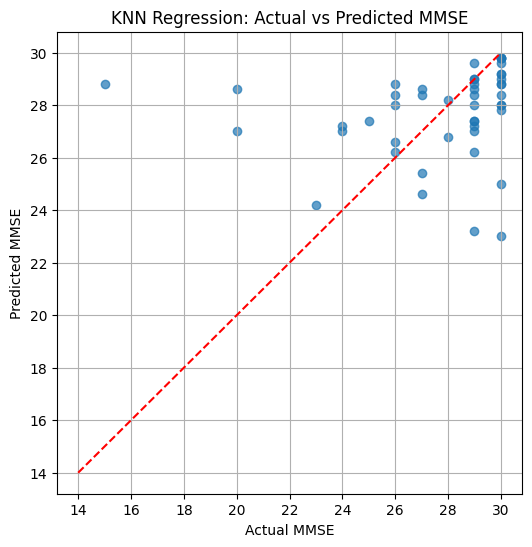

In [61]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')  # reference line
plt.xlabel("Actual MMSE")
plt.ylabel("Predicted MMSE")
plt.title("KNN Regression: Actual vs Predicted MMSE")
plt.grid(True)
plt.show()


In [62]:
import pandas as pd

results = {
    "Model Version": ["Before Fine Tuning", "After Fine Tuning"],
    "R² Score": [0.46, -0.13], 
    "RMSE": [0.36, 0.33]
}

df_results = pd.DataFrame(results)
print(df_results)


        Model Version  R² Score  RMSE
0  Before Fine Tuning      0.46  0.36
1   After Fine Tuning     -0.13  0.33
